In [1]:
# Libraries
import numpy as np
import scipy.io as sio
import os
# import pickle
# import re
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
# from scipy import stats
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import svm, linear_model
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Function for extracting channel names from filename
def chan_labels_from_fname(in_file):
    just_fname=in_file.split('/')[-1]
    jf_splt=just_fname.split('_')
    chan_label=jf_splt[1]+'-'+jf_splt[2]
    return chan_label

In [3]:
# Get size of a subject's data (and filenames)
def data_size_and_fnames(sub_list,ftr_root):
    grand_non_fnames=list()
    grand_szr_fnames=list()
    grand_n_szr_wind=0
    grand_n_non_wind=0
    for sub in sub_list:
        print('Working on sub %d' % sub)
        non_fnames=list()
        szr_fnames=list()
        
        ftr_path=os.path.join(ftr_root,str(sub))
        for f in os.listdir(ftr_path):
            if f.endswith('non.mat'):
                non_fnames.append(os.path.join(ftr_root,str(sub),f))
            elif f.endswith('.mat') and f.startswith(str(sub)+'_'):
                szr_fnames.append(os.path.join(ftr_root,str(sub),f))

        print('%d non-szr files found' % len(non_fnames))
        print('%d szr files found' % len(szr_fnames))  

        # Loop over NON-szr files to get total # of windows
        n_non_wind=0
        ftr_dim=0
        for f in non_fnames:
#             in_file=os.path.join(ftr_path,f)
#             temp_ftrs=sio.loadmat(in_file)
            temp_ftrs=sio.loadmat(f)
            n_non_wind+=temp_ftrs['nonszr_se_ftrs'].shape[1]
            if ftr_dim==0:
                ftr_dim=temp_ftrs['nonszr_se_ftrs'].shape[0]
            elif ftr_dim!=temp_ftrs['nonszr_se_ftrs'].shape[0]:
                raise ValueError('# of features in file does match previous files')

        print('%d total # of NON-szr time windows for this sub' % n_non_wind)

        # Loop over SZR files to get total # of windows
        n_szr_wind=0
        for f in szr_fnames:
#             in_file=os.path.join(ftr_path,f)
#             temp_ftrs=sio.loadmat(in_file)
            temp_ftrs=sio.loadmat(f)
            n_szr_wind+=temp_ftrs['se_ftrs'].shape[1]
        print('%d total # of SZR time windows for this sub' % n_szr_wind)
        
        grand_non_fnames+=non_fnames
        grand_szr_fnames+=szr_fnames
        grand_n_szr_wind+=n_szr_wind
        grand_n_non_wind+=n_non_wind
        
    return grand_szr_fnames, grand_non_fnames, grand_n_szr_wind, grand_n_non_wind, ftr_dim

In [8]:
def import_data(szr_fnames, non_fnames, n_szr_wind, n_non_wind, ftr_dim):
    #ftr_path=os.path.join(ftr_root,str(sub))
        
    # Preallocate memory
    ftrs=np.zeros((ftr_dim,n_szr_wind+n_non_wind))
    targ_labels=np.zeros(n_szr_wind+n_non_wind)

    # Import non-szr data
    ptr=0
    mns_dict=dict()
    sds_dict=dict()
    for f in non_fnames:
        chan_label=chan_labels_from_fname(f)
#         in_file=os.path.join(ftr_path,f)
#         chan_label=chan_labels_from_fname(in_file)

        temp_ftrs=sio.loadmat(f)
        temp_n_wind=temp_ftrs['nonszr_se_ftrs'].shape[1]
        raw_ftrs=temp_ftrs['nonszr_se_ftrs']
        # Z-score features
        temp_mns, temp_sds=dg.trimmed_normalize(raw_ftrs,0)
        mns_dict[chan_label]=temp_mns
        sds_dict[chan_label]=temp_sds
    
        ftrs[:,ptr:ptr+temp_n_wind]=raw_ftrs
        targ_labels[ptr:ptr+temp_n_wind]=0
        ptr+=temp_n_wind

    # Import szr data
    for f in szr_fnames:
        chan_label=chan_labels_from_fname(f)
#         in_file=os.path.join(ftr_path,f)
#         chan_label=chan_labels_from_fname(in_file)

        #temp_ftrs=sio.loadmat(in_file)
        temp_ftrs=sio.loadmat(f)
        temp_n_wind=temp_ftrs['se_ftrs'].shape[1]
        raw_ftrs=temp_ftrs['se_ftrs']
        # Z-score based on non-ictal means, SDs
        dg.applyNormalize(raw_ftrs,mns_dict[chan_label],sds_dict[chan_label])

        ftrs[:,ptr:ptr+temp_n_wind]=raw_ftrs
        targ_labels[ptr:ptr+temp_n_wind]=1;
        ptr+=temp_n_wind

    return ftrs, targ_labels

In [10]:
# non_fnames_trORIG=non_fnames_tr
# szr_fnames_tr
print(non_fnames_tr)
print(train_subs)
print(non_fnames_tr[-1])
print(chan_labels_from_fname(non_fnames_tr[-1]))

['/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096/1096_HL1_HL2_non.mat', '/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096/1096_HL2_HL3_non.mat', '/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096/1096_HL3_HL4_non.mat', '/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096/1096_HL4_HL5_non.mat', '/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096/1096_HL5_HL6_non.mat', '/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096/1096_HL6_HL7_non.mat', '/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096/1096_HL7_HL8_non.mat', '/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096/1096_HL8_HL9_non.mat']
[1096]
/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096/1096_HL8_HL9_non.mat
HL8-HL9


In [14]:
# Get Training Data
train_subs=[1096, 620]
#/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096_HL1_HL2_non.ma
ftr_root='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/'
szr_fnames_tr, non_fnames_tr, n_szr_wind_tr, n_non_wind_tr, ftr_dim=data_size_and_fnames(train_subs, ftr_root)
ftrs_tr, targ_labels_tr=import_data(szr_fnames_tr, non_fnames_tr, n_szr_wind_tr, n_non_wind_tr, ftr_dim)

Working on sub 1096
8 non-szr files found
40 szr files found
49665 total # of NON-szr time windows for this sub
49297 total # of SZR time windows for this sub
Working on sub 620
5 non-szr files found
14 szr files found
8960 total # of NON-szr time windows for this sub
8210 total # of SZR time windows for this sub
30 dimensions
3795 observations
30 dimensions
5940 observations
30 dimensions
11220 observations
30 dimensions
11220 observations
30 dimensions
4950 observations
30 dimensions
4950 observations
30 dimensions
3795 observations
30 dimensions
3795 observations
30 dimensions
1280 observations
30 dimensions
1280 observations
30 dimensions
2048 observations
30 dimensions
3072 observations
30 dimensions
1280 observations


In [19]:
# Train & Evaluate Model on Training Data
# Train classifier
C=1
model = linear_model.LogisticRegression(C=C,class_weight='balanced')
model.fit(ftrs_tr.T, targ_labels_tr)
class_hat_tr = model.predict_proba(ftrs_tr.T)[:,1]
print('Training Data Performance')
auc_tr=roc_auc_score(targ_labels_tr, class_hat_tr)
print('AUC=%.3f' % auc_tr)
bal_acc_tr, sens_tr, spec_tr=ief.perf_msrs(targ_labels_tr, class_hat_tr>=0.5)
print('Balanced Accuracy (sens/spec)=%.3f (%f/%f)' % (bal_acc_tr,sens_tr,spec_tr))

Training Data Performance
AUC=0.935
Balanced Accuracy (sens/spec)=0.859 (0.818596/0.898968)


In [18]:
print(targ_labels_tr.shape)
print(49665+49297+8960+8210)

(116132,)
116132


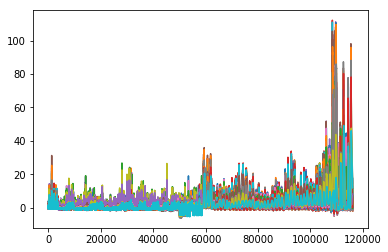

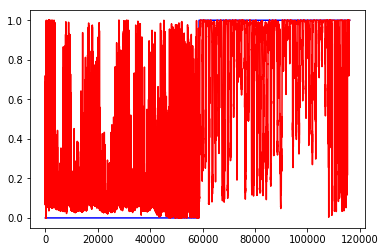

In [20]:
plt.figure(11)
plt.clf()
plt.plot(ftrs_tr.T);

plt.figure(12)
plt.clf()
plt.plot(targ_labels_tr,'b-');
plt.plot(class_hat_tr,'r-');

In [ ]:
# Load Validation Data
# Get Training Data
valid_subs=620 #TODO MAKE THIS A LIST
szr_fnames_va, non_fnames_va, n_szr_wind_va, n_non_wind_va, ftr_dim=data_size_and_fnames(valid_subs, ftr_root)
ftrs_va, targ_labels_va=import_data(szr_fnames_va, non_fnames_va, n_szr_wind_va, n_non_wind_va, ftr_dim, ftr_root, valid_subs)

In [ ]:
# Evaluate Model on Validation Data
class_hat_va = model.predict_proba(ftrs_va.T)[:,1]
print('Validation Data Performance')
auc_va=roc_auc_score(targ_labels_va, class_hat_va)
print('AUC=%.3f' % auc_va)
bal_acc_va, sens_va, spec_va=ief.perf_msrs(targ_labels_va, class_hat_va>=0.5)
print('Balanced Accuracy (sens/spec)=%.3f (%f/%f)' % (bal_acc_va,sens_va,spec_va))